In [1]:
import numpy as np  # Biblioteca NumPy, utilizada para a maior parte das operações matemáticas;

import matplotlib.pyplot as plt # Biblioteca Matplotlib.Pyplot, encarregada de plotar os gráficos;
from matplotlib import rc # Sub-pacote do matplotlib, necessário para a formatação em LateX;

from scipy.interpolate import make_interp_spline # Função make_interp_spline, que interpola funções obtidas e suaviza os plots;
from scipy.special import spherical_jn # função spherical_jn, calcula os esféricos de Bessel e suas derivadas;
from scipy.special import sph_harm # função sph_harm, que calcula os esféricos harmônicos

from scipy import integrate # Sub-pacote Integrate do Scipy, utilizado para realizar integrações simples e duplas através de Coeficientes de Clebshaw-Curtis;
    
import time as time # Pacote Time, utilizado para manter um registro do tempo computacional de cada operação.

In [2]:
# Nesta célula de programa, iremos definir as propriedades das caixas que iremos produzir.

linear_distance = 500 # Tamanho lateral da caixa, em Mpc/h;

N_bins = 100    #Número de células por eixo cartesiano;

Delta_L = linear_distance/N_bins # Tamanho lateral das células, em Mpc/h;

xyz_edges = np.arange(0, linear_distance + 0.5, Delta_L) # Posição do canto das células, em Mpc/h;

xyz_centr = 0.5 * (xyz_edges[1:] + xyz_edges[:-1]) # Posição central das células, em Mpc/h;

# Definindo as respectivas 'frequências' da caixa no espaço de Fourier definido pelo NumPy: a definição do NumPy para a frequência é o nosso k usual dividido por 2*pi/Delta_L .


k_xyz = np.fft.fftfreq(N_bins) # Vetor de Frequências do NumPy;

# Criando um grid 3D que nos diz a distância radial k de cada célula no espaço de Fourier: grid_k

ident = np.ones_like(k_xyz) 
KX2 = np.einsum('i,j,k', k_xyz**2, ident, ident)
KY2 = np.einsum('i,j,k', ident, k_xyz**2, ident)
KZ2 = np.einsum('i,j,k', ident, ident, k_xyz**2)
grid_k = np.sqrt(KX2 + KY2 + KZ2) # grid dos valores radiais de k em cada célula no espaço de Fourier (definição normalizada do NumPy) 

k_max = 2*np.pi*np.max(k_xyz)/Delta_L # Escala máxima da nossa caixa, k_max
k_min = 2*np.pi/linear_distance # Escala mínima da caixa, k_min

# Avaliação da função de Correlação no Espaço de Fourier : Subdividimos a nossa caixa no espaço de Fourier em 'nbinsk' bins 'radiais' , de forma que realizamos a média das correlações encontradas dentro desses volumes.

nbinsk = int(9*N_bins/10) # nbinsk, número de bins que subdividimos nossa caixa
k_bins = np.arange(k_min, k_max, (k_max - k_min) / nbinsk) # posição do canto de cada bin k_i
k_ctrs = 0.5 * (k_bins[1:] + k_bins[:-1]) # posição central de cada bin k_i
n_k = len(k_bins) - 1 # número de bins k_i

# Propriedades das células no espaço real :

x=np.arange(N_bins) # Posição de cada célula, em unidade de células ( 1 célula = 5 Mpc/h );
x=x-N_bins/2  # Reposicionando a origem para o centro da caixa;

# Criando um grid 3D que nos diz a distância radial r de cada célula no espaço real : r_grid

x_ones=np.ones_like(x)
x_grid = np.einsum('i,j,k', x, x_ones, x_ones)
y_grid = np.einsum('i,j,k', x_ones, x, x_ones)
z_grid = np.einsum('i,j,k', x_ones, x_ones, x)

r_grid = np.sqrt( x_grid**2 + y_grid**2 + z_grid**2 + 0.000001) # versão de r_grid adicionado por um valor infinitesimal, a fim de evitar divisões por zero no cálculo de ângulos das coordenadas esféricas.

r_grid2 = np.sqrt( x_grid**2 + y_grid**2 + z_grid**2) # r_grid2 : versão pura da distância radial de cada célula, em unidade de células.

phi_grid=np.arctan2(y_grid,x_grid) # valor do ângulo phi para cada célula;

theta_grid=np.arccos(z_grid/r_grid) # valor do ângulo theta para cada célula;

cos_theta_grid=z_grid/r_grid # valor de cos(theta) para cada célula;

rho_grid=np.sqrt(x_grid**2+y_grid**2+0.000001) # valor do raio polar rho para cada célula;

sin_theta_grid=rho_grid/r_grid # valor de sen(theta) para cada célula;

sin_phi_grid=x_grid/rho_grid # valor de sen(phi) para cada célula;

cos_phi_grid=y_grid/rho_grid # valor de cos(phi) para cada célula

# Cálculo do elemento diferencial do ângulo sólido, d_Omega, para cada célula: Cada célula é tratada como se tivesse três faces quadradas, uma para cada eixo cartesiano. Dessa forma, o valor do ângulo sólido é grandemente simplificado:

d_Omega_grid=np.abs((sin_theta_grid*cos_phi_grid+sin_theta_grid*sin_phi_grid+cos_theta_grid)/(r_grid**2))

In [3]:
# Algumas funções essenciais :



# Função delta de kronecker para dois índices a,b :

def kronecker(a,b):
    
    if a==b:
        
        return 1
    
    else:
        
        return 0

    

# Função 'Top-Hat' para o Espectro de Potência da matéria, dado um valor de epsilon (eps), k_1 e k_2. Em função do número de onda k cosmológico (h/Mpc).
    
def tophat(eps,k1,k2,k):
    
    res=eps*np.heaviside(k-k1,0.5)-eps*np.heaviside(k-k2,0.5) # np.heaviside é a função Passo de Heaviside.
    
    return res

# função que fornece uma amostra aleatória (Gaussiana+Poissoniana) do campo de contraste de densidade seguindo o Top-Hat, dado um (ou mais) bias do traçador (b1), e suas respectivas densidades (N1, em [Delta_L^(-3)]). Irá retornar um campo para cada Traçador fornecido.
 
def random_delta_tracers(b1,N1):
    
    # criando amostras gaussianas do módulo dos modos de Fourier ( np.random.normal ) , e atribuindo uma fase complexa aleatória ( np.exp )
    
    delta_gaussian = np.random.normal(0.0, np.sqrt((linear_distance)**3*tophat(epsilon,k_1,k_2,(2*np.pi/Delta_L)*grid_k))) * np.exp(1j * 2*np.pi * np.random.uniform(0, 1, grid_k.shape))
    
    # Condição de modos no espaço real puramente reais.
    
    delta_fourier = delta_gaussian[:,:,:N_bins//2+1] 
    
    # Tomando a transformada de Fourier inversa para obtermos o campo de contraste de densidade da matéria. (obs: o fator (1/Delta_L)**3 é adicionado pois a transformada inversa é composta de uma integral em dk³, que não possui dimensão na definição do NumPy. Portanto, só estamos contabilizando a dimensionalidade das nossas frequências )
    
    delta_real = (1/Delta_L)**3*np.fft.irfftn(delta_fourier)
    
    delta_tracers=np.zeros(shape=(len(b1),N_bins,N_bins,N_bins))
    
    for i in range(len(b1)):
        
        # versão discretizada do campo de contraste de densidade do traçador, tomando-se uma amostra Poissoniana ( np.random.poisson ) da expressão teórica.
        
        delta_tracers[i,:,:,:]=(np.random.poisson(N1[i]*(1+b1[i]*delta_real))-N1[i])/N1[i]
    
    return delta_tracers

# função que calcula os modos harmônicos delta_lm do contraste de densidade, dado um campo de contraste (delta),
# um valor para l (l3), o campo de elementos diferenciais do ângulo sólido (d_omega), e o bin radial em que se quer
# calcular este módulo, dado por uma máscara (mask) que só considerará como não-nulo as células dentro deste bin. Por fim,
# tudo é normalizado pelo fator norm, que nada mais é que a somatória de d_omega neste bin radial.

#A função retornará todos os valores de delta_lm, l fixo, m indo de -l até +l (2l+1 modos no total). 

def delta_lm(l3,delta,d_omega,norm,harm,mask):

    res=np.zeros(int(2*l3)+1,dtype='complex')
    
    for i in range(int(2*l3)+1):
        
        harm_m=harm[i,:,:,:]
        res[i]= np.sum ( d_omega * harm_m[mask] * delta ) 
        
    return norm * res

# função que calcula o campo de Esféricos Harmônicos para cada posição da célula, dado um l fixo.
# retorna (2l+1) campos, um para cada modo m.

def compute_Harmonics(l2):
    
    res=np.zeros(shape=(int(2*l2)+1,N_bins,N_bins,N_bins),dtype='complex')
    m=np.linspace(-l2,l2,int(2*l2)+1)
    
    for i in range(len(m)):
        
        res[i,:,:,:]=np.conj(sph_harm(int(m[i]),int(l2),phi_grid,theta_grid))
    
    return res

# Função que calcula a função de correlação dos modos harmônicos <delta_lm(r1),delta_lm(r2)>, dado o número de caixas
# aleatórias a serem produzidas (N_sims), um vetor de l's a serem avaliados (l1), um vetor de bias de traçador a ser analisado
# (b1), e suas respectivas densidades (N1), um vetor de raios (r1) e (r2) a serem analisados. Por fim, a espessura (W)
# de cada bin radial a ser considerado na hora de calcular os modos harmônicos delta_lm .

# Irá retornar os estimadores da função de correlação obtida para cada caixa, para cada valor de l,r1,r2,b1, de forma que 
# podemos tomar a média sobre estes estimadores a fim de obtermos o valor final para a função de correlação propriamente dita.


def Angular_PS_tracers(N_sims,l1,b1,N1,r1,r2,W):
    
    

    res=np.zeros(shape=(N_sims,len(l1),len(b1),len(b1),len(r1),len(r2)),dtype='complex')
    

            
    for i in range(len(l1)):
        
        Harmonics=compute_Harmonics(l1[i]) # Pré-Calcula os Esféricos Harmônicos Y_lm , l fixo ( l1[i] ), -l <= m <= l
            
        for a in range(N_sims):
            
            delta_tracers=random_delta_tracers(b1,N1) # campo aleatório Gaussiano é criado
            
            for u in range(len(b1)):
        
                delta_1=delta_tracers[u] # Campo aleatório do traçador b1[u]
        
                for v in range(len(b1)):
            
                    delta_2=delta_tracers[v] # Campo aleatório do traçador b1[v]
                    
                    
                    for j in range(len(r1)):
                        
                        # máscara do bin r1[j]
                        mask_r1=np.where((r_grid2>=(r1[j]/Delta_L-W/(2*Delta_L))) & (r_grid2<=(r1[j]/Delta_L+W/(2*Delta_L))))
                        # normalização do ângulo sólido 
                        norm_r1=4*np.pi/np.sum(d_Omega_grid[mask_r1])
                        # Campo do Ângulo Sólido mascarado pelo bin 
                        d_omega_r1=d_Omega_grid[mask_r1]                        
                        # Campo do contraste de densidade mascarado pelo bin
                        delta_r1=delta_1[mask_r1]
                    
                        for k in range(len(r2)):
                            
                            # máscara do bin r2[k]
                            mask_r2=np.where((r_grid2>=(r2[k]/Delta_L-W/(2*Delta_L))) & (r_grid2<=(r2[k]/Delta_L+W/(2*Delta_L))))
                            # normalização do ângulo sólido 
                            norm_r2=4*np.pi/np.sum(d_Omega_grid[mask_r2])
                            # Campo do Ângulo Sólido mascarado pelo bin 
                            d_omega_r2=d_Omega_grid[mask_r2]
                            # Campo do contraste de densidade mascarado pelo bin
                            delta_r2=delta_2[mask_r2]
                            # Cálculo dos modos Harmônicos delta_lm(r1[j]) , delta_lm*(r2[k]) , para cada modo m degenerado.
                            deltas_lm_1=delta_lm(l1[i],delta_r1,d_omega_r1,norm_r1,Harmonics,mask_r1)
                            deltas_lm_2=np.conj(delta_lm(l1[i],delta_r2,d_omega_r2,norm_r2,Harmonics,mask_r2))
                            # por fim, média sobre os modos m para obtenção dos estimadores da função de correlação
                            res[a,i,u,v,j,k]= np.mean( deltas_lm_1*deltas_lm_2 )
                
    return res

# Função g_l definida pela equação (67)

def g2(l1,a,b):
    
    a2=a+1e-10
    res=(b*spherical_jn(l1-1,b)*spherical_jn(l1,a2)-a2*spherical_jn(l1-1,a2)*spherical_jn(l1,b))/(a2**2-b**2)
   
    return np.nan_to_num(res)

# Expressão teórica para a função de correlação dos modos harmônicos : versão de bin infinitesimal

def Angular_PS_theory2(ls,b1,n1,r1,r2): 

    res=np.zeros(shape=(len(ls),len(b1),len(b1),len(r1),len(r2)),dtype='complex')
    
    for i in range(len(ls)):
        for j in range(len(r1)):
            for k in range(len(r2)):
                for u in range(len(b1)):
                    for v in range(len(b1)):
                        
                        res[i,u,v,j,k] =  kronecker(b1[u],b1[v])*kronecker(r1[j],r2[k])*Delta_L**3/(n1[u]*r2[k]**2*Delta_L) - (2/np.pi)*b1[u]*b1[v]*epsilon*(k_1**3*g2(ls[i],k_1*r1[j],k_1*r2[k])-k_2**3*g2(ls[i],k_2*r1[j],k_2*r2[k]))
        
    return res

# Expressão teórica para a função de correlação dos modos harmônicos : versão 'binada', com integral sobre o volume dos bins

def Angular_PS_theory_avg2(ls,b1,n1,r1,r2,W):

    res=np.zeros(shape=(len(ls),len(b1),len(b1),len(r1),len(r2)))
    
    for i in range(len(ls)):
        for j in range(len(r1)):
            for k in range(len(r2)):
                for u in range(len(b1)):
                    for v in range(len(b1)):
                        
                        # função a ser integrada
                        func = lambda R1, R2: R2**2*R1**2*( kronecker(b1[u],b1[v])*kronecker(r1[j],r2[k])*Delta_L**3/(n1[u]*R2**2*Delta_L)  - (2/np.pi)*b1[u]*b1[v]*epsilon*(k_1**3*g2(ls[i],k_1*R1,k_1*R2)-k_2**3*g2(ls[i],k_2*R1,k_2*R2)) )
                        # termo volumétrico com o qual normalizaremos a integral
                        volume_term=((r2[k]+W/2)**3-(r2[k]-W/2)**3)*((r1[j]+W/2)**3-(r1[j]-W/2)**3)/9
                        # realização da integral sobre o intervalo dos bins + normalização
                        res[i,u,v,j,k]=integrate.dblquad(func, r2[k]-W/2, r2[k]+W/2, lambda R1: r1[j]-W/2, lambda R1: r1[j]+W/2)[0]/volume_term
                                
                                

    return res

# Função que calcula as matrizes de covariância do espectro de potência angular, isto é, Cov[xi_l^(b1,b2)(X),xi_l^(b3,b4)(Y)],
# tanto amostral quanto teórica,
# dados l (l1), (b1,b2) e (b3,b4) fixos, provenientes de uma simulação (sim1) e teoria (simth1) pré-computadas.

def complete_cov_r1r2r3r4(sim1,simth1,l1,b1,b2,b3,b4,W):
    
    # índice do vetor l_1 da simulação que corresponde a l_1=l1
    
    l_index=int(np.where(l_1==np.double(l1))[0])
    
    # índices no vetor biass da simulação que correspondem a b1,b2,b3 e b4
    
    b1_index=int(np.where(biass==np.double(b1))[0])
    b2_index=int(np.where(biass==np.double(b2))[0])
    b3_index=int(np.where(biass==np.double(b3))[0])
    b4_index=int(np.where(biass==np.double(b4))[0])
    
    # número de bins radiais
    
    r1len=len(sim1[0,0,0,0,:,0])
    
    # número de caixas produzidas pela simulação
    
    simsampleslen=len(sim1[:,0,0,0,0,0])
    
    # matrizes r1 x r2 para (o estimador da) função de correlação dos traçadores b1 e b2 , para cada caixa simulada.
    
    cl1sim=np.real(sim1[:,l_index,b1_index,b2_index,:,:])
    
    # matrizes r1 x r2 para (o estimador da) função de correlação dos traçadores b3 e b4 , para cada caixa simulada.
    
    cl2sim=np.real(sim1[:,l_index,b3_index,b4_index,:,:])   
    
    # Tamanho de entradas laterais da matriz
    
    Xlen=r1len**2  
    
    CLX_vec_samples=np.zeros(shape=(simsampleslen,Xlen))
    CLY_vec_samples=np.zeros(shape=(simsampleslen,Xlen))
    
    # versões teóricas de C_l, para diferentes combinações de traçadores ( utilizado na expressão teórica da 
    # matriz de covariância )
    
    CL1_vec_theory=np.real(simth1[l_index,b1_index,b3_index,:,:])
    CL2_vec_theory=np.real(simth1[l_index,b2_index,b4_index,:,:])
    CL3_vec_theory=np.real(simth1[l_index,b1_index,b4_index,:,:])
    CL4_vec_theory=np.real(simth1[l_index,b3_index,b2_index,:,:])
    
    # criando i vetores 'flat' das funções de correlação (np.matrix.flatten), 
    # de forma que de matrizes r1 x r2 teremos vetores de tamanho Xlen= r1*r2 .
    
    for i in range(simsampleslen):
        
        # vetor flat da função de correlação cl1sim, para cada caixa simulada
        
        CLX_vec_samples[i][:]=np.matrix.flatten(cl1sim[i,:,:])
        
        # vetor flat da função de correlação cl2sim, para cada caixa simulada
        
        CLY_vec_samples[i][:]=np.matrix.flatten(cl2sim[i,:,:] )
            
    covmatrix=np.zeros(shape=(Xlen,Xlen))
    covmatrix_theory=np.zeros(shape=(Xlen,Xlen))
    
    
    for i in range(Xlen):
        for j in range(Xlen):
            
            if j<=i: # evita o cálculo duplo, já que esta matriz é simétrica.
                
                # índices teóricos de r1,r2,r3 e r4 em cada entrada da matriz de covariância
                
                r1_index=np.unravel_index([i], (r1len,r1len))[0]
                r2_index=np.unravel_index([i], (r1len,r1len))[1]
                r3_index=np.unravel_index([j], (r1len,r1len))[0]
                r4_index=np.unravel_index([j], (r1len,r1len))[1]
                
                # matriz de covariância: para cada valor de (r1,r2) [i] e (r3,r4) [j] , tomamos a covariância amostral
                # das várias caixas simuladas. ([0,1] abaixo serve simplesmente para tomarmos a covariância cruzada, que é
                # o que queremos)
                
                covmatrix[i,j]=np.cov(CLX_vec_samples[:,i],CLY_vec_samples[:,j])[0,1]
                
                # Expressão teórica para a matriz de covariância, dados os índices corretos para os bins radiais.
                covmatrix_theory[i,j]=(CL1_vec_theory[r1_index,r3_index]*CL2_vec_theory[r2_index,r4_index]+CL3_vec_theory[r1_index,r4_index]*CL4_vec_theory[r3_index,r2_index])/(2*l1+1)
        
    for i in range(Xlen):
        for j in range(Xlen):    
    
            if j>i: # o triângulo inferior é igual ao superior, por simetria.
            
                covmatrix[i,j]=covmatrix[j,i]
                covmatrix_theory[i,j]=covmatrix_theory[j,i]
    
    # função retorna as matrizes de covariância amostral e teórica .
    return covmatrix,covmatrix_theory

Vamos agora realizar alguns cálculos relacionados às simulações: primeiramente, vamos calcular a variância esférica das nossas caixas. Abaixo, as funções necessárias para realizarmos estes cálculos:

In [4]:
# Expressão teórica para a variância esférica de um traçador b1 , com respectiva densidade de contagem de traçadores N1, raio r:

def sigma_tracer_theory(b1,N1,r):
    
    res1=np.sqrt( np.sum( dk1 * (kh[1:]**2*(Delta_L**3/N1+b1**2*tophat(epsilon,k_1,k_2,kh[1:]))/(2*np.pi**2))*(3*spherical_jn(1,kh[1:]*r)/(kh[1:]*r))**2 ) )

    return res1

# Função que calcula a variância esférica amostral e plota diretamente a comparação com a expressão teórica, dado um número 
# Ns de pontos aleatórios sobre os quais avaliaremos a variância esférica amostral, e então realizaremos uma média.

def plot_sigma_tracer(b1,N1,Ns):
    
    respartial=np.zeros(shape=(int(N_bins/2),Ns))
    
    bias1=[b1]
    N_bar1=[N1]
    
    for i in range(Ns):
        # para cada ponto i aleatório, criamos um campo de contraste de densidade aleatório também.
        
        delta1=random_delta_tracers(bias1,N_bar1)[0,:,:,:]
        
        # tomando um ponto aleatório dentro da caixa recém-criada
        
        rand_x=int(np.random.uniform(0,N_bins-1))
        rand_y=int(np.random.uniform(0,N_bins-1))
        rand_z=int(np.random.uniform(0,N_bins-1))
        
        # criando um grid de valor radial no qual a origem está centrada no ponto aleatório
        
        x2=np.arange(N_bins)-rand_x
        y2=np.arange(N_bins)-rand_y
        z2=np.arange(N_bins)-rand_z
        
        x2_grid = np.einsum('i,j,k', x2, x_ones, x_ones)
        y2_grid = np.einsum('i,j,k', x_ones, y2, x_ones)
        z2_grid = np.einsum('i,j,k', x_ones, x_ones, z2)
        
        r_grid2 = np.sqrt( x2_grid**2 + y2_grid**2 + z2_grid**2 ) # grid radial do ponto aleatório
        
        for j in range(int(N_bins/2)):
            
            # máscara que só levará em conta células dentro da esfera de raio (j*(N_bins/2)) centrada no ponto aleatório gerado
            
            center_sphere=np.where(r_grid2<=j)
            
            # valor da variância esférica para uma caixa aleatória de ponto aleatório i, raio (j*(N_bins/2)) .
            
            respartial[j,i]=np.sqrt(np.mean(np.real(delta1[center_sphere]))**2)
            
    # cálculo da variância da estimativa para a variância esférica em cada raio:
    
    res_var=np.zeros(int(N_bins/2))
    
    for i in range(int(N_bins/2)):
        
         res_var[i]=np.sqrt(np.var(respartial[i,:]))
                
                
    
    # Cálculo da variância esférica amostral propriamente dita, realizando-se uma média sobre os Ns pontos aleatórios,
    # juntamente com o cálculo teórico dada pela função anterior.
    
    res=np.zeros(int(N_bins/2))
    resth=np.zeros(int(N_bins/2))
    
    for i in range(int(N_bins/2)):
        
        res[i]=np.mean(respartial[i,:]) # variância esférica amostral
        resth[i]=sigma_tracer_theory(b1,N1,Delta_L*i+1e-5) # variância esférica teórica ( obs: valor infinitesimal adicionado 
        # ao valor do raio, para evitar divisão por zero )
    
    
    #### interpolando os resultados para uma visualização suavizada ######
    
    r_interp=np.linspace(0,Delta_L*int(N_bins/2),125)
    
    res_interp=make_interp_spline(Delta_L*np.arange(int(N_bins/2)),res)
    resvar_interp=make_interp_spline(Delta_L*np.arange(int(N_bins/2)),res_var)
    resth_interp=make_interp_spline(Delta_L*np.arange(int(N_bins/2)),resth)
    
    
    ##########  Plot da variância esférica versus raio  #############
    
    plt.figure(figsize=(15,7))
    plt.semilogx(r_interp,res_interp(r_interp),label=r"Variância Amostral")
    plt.semilogx(r_interp,resth_interp(r_interp),label=r"Variância Teórica")
    plt.fill_between(r_interp,res_interp(r_interp)-resvar_interp(r_interp),res_interp(r_interp)+resvar_interp(r_interp),alpha=0.2,color='blue')
    plt.xlim(right=linear_distance/2)
    plt.xlabel(r"$R\,\,\,[\,h^{-1}\,Mpc\,]$",fontsize=20)
    plt.ylabel(r"$\sigma_R^{%i}$"%b1,fontsize=20)
    plt.title(r"Variância Esférica  $\sigma^{%i}_R$"%b1,fontsize=20)
    plt.tick_params(labelsize=20)
    plt.legend(fontsize=20)
    plt.grid() 
    plt.show()

Com as funções acima, podemos finalmente mostrar o plot da variância esférica das caixas criadas seguindo
o espectro de potência 'top-hat' :

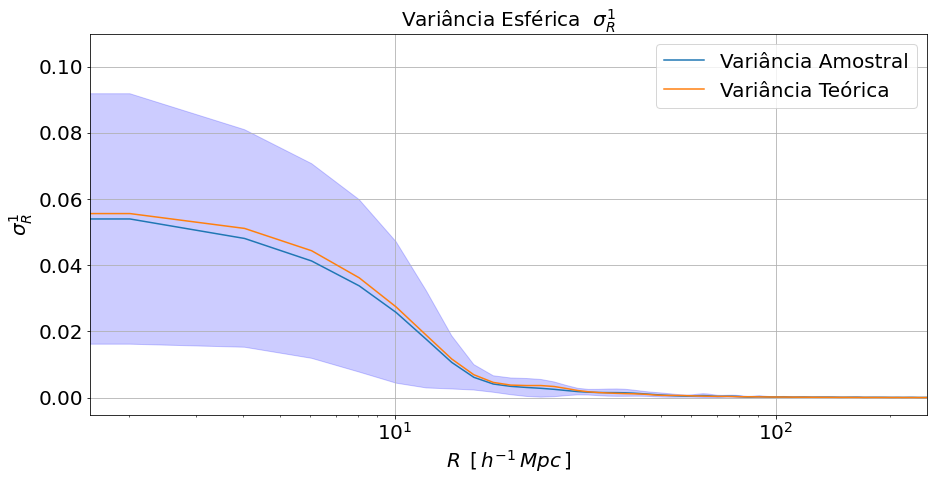

In [5]:
# Definindo as constantes do modelo Top-Hat :

epsilon=10
k_1=2e-1
k_2=3e-1

# Definindo o intervalo de frequências sobre o qual integraremos a expressão teórica para a variância esférica 

kh=np.logspace(np.log10(k_1),np.log10(k_2),1000,10)
dk1=np.abs(kh[1:]-kh[:-1])

# Plot da variância esférica amostral versus teórica, para um traçador de bias 1, densidade de contagem 1000 [Delta_L^(-3)]
# e média sobre 20 pontos aleatórios:

plot_sigma_tracer(1,1000,20)

Em seguida, vamos calcular a função de correlação dos modos de Fourier gerados através das amostras aleatórias 
(Gaussianas+Poissonianas). Para isso, é útil definir a seguinte função:

In [22]:
# Função que gera um campo de contraste de densidade no espaço de Fourier, para um dado bias b1 de densidade de contagem
# de traçadores N1 [Delta_L^(-3)] . em seguida, a função toma a auto-correlação dos modos de Fourier dentro dos bins k_ctrs,
# definidos logo no início do programa.

def random_ps_tracers(b1,N1):
    
    # criando amostras gaussianas do módulo dos modos de Fourier ( np.random.normal ) ,
    # e atribuindo uma fase complexa aleatória ( np.exp )
    
    delta_gaussian = np.random.normal(0.0, np.sqrt((linear_distance)**3*tophat(epsilon,k_1,k_2,(2*np.pi/Delta_L)*grid_k))) * np.exp(1j * 2*np.pi * np.random.uniform(0, 1, grid_k.shape))
    
    # Condição de modos no espaço real puramente reais.
    
    delta_fourier = delta_gaussian[:,:,:N_bins//2+1] 
    
    # Tomando a transformada de Fourier inversa para obtermos o campo de contraste de densidade da matéria.
    # (obs: o fator (1/Delta_L)**3 é adicionado pois a transformada inversa é composta de uma integral em dk³, que não possui
    # dimensão na definição do NumPy. Portanto, só estamos contabilizando a dimensionalidade das nossas frequências )
    
    delta_real = (1/Delta_L)**3*np.fft.irfftn(delta_fourier)
    
    
    delta_tracers=np.zeros(shape=(N_bins,N_bins,N_bins))
    
    delta_fourier_tracers=np.zeros(shape=(N_bins,N_bins,N_bins))
    
    # versão discretizada do campo de contraste de densidade do traçador, tomando-se uma amostra Poissoniana
    # ( np.random.poisson ) da expressão teórica.
    
    delta_tracers=(np.random.poisson(N1*(1+b1*delta_real))-N1)/N1
    
    # Modos de Fourier do contraste de densidade dos traçadores, tomando-se a transformada de Fourier destes.
    # (obs: a inclusão do termo (Delta_L)³ é realizada pelo mesmo argumento da obtenção de delta_real, só que agora
    # devido à uma integral em dx³ )
    
    delta_fourier_tracers=np.fft.fftn(delta_tracers)*(Delta_L)**3
                
    amp_disc=np.zeros(shape=(n_k))
    
    # Tomando a função de correlação dentro dos i bins em k:
    
    for i in range(n_k):
    
        amp_disc[i] = np.mean(np.abs(delta_fourier_tracers[ ((2*np.pi/Delta_L)*grid_k > k_bins[i]) & ((2*np.pi/Delta_L)*grid_k <= k_bins[i+1]) ])**2.)
        
    return amp_disc

Criada a função que calcula a função de correlação (para apenas uma caixa), vamos realizar um plot comparando a média desta função para 'N_amostras' amostras dos modos de Fourier (que é, de fato, a função de correlação) versus o valor teórico esperado para esses modos, dado pela equação ():

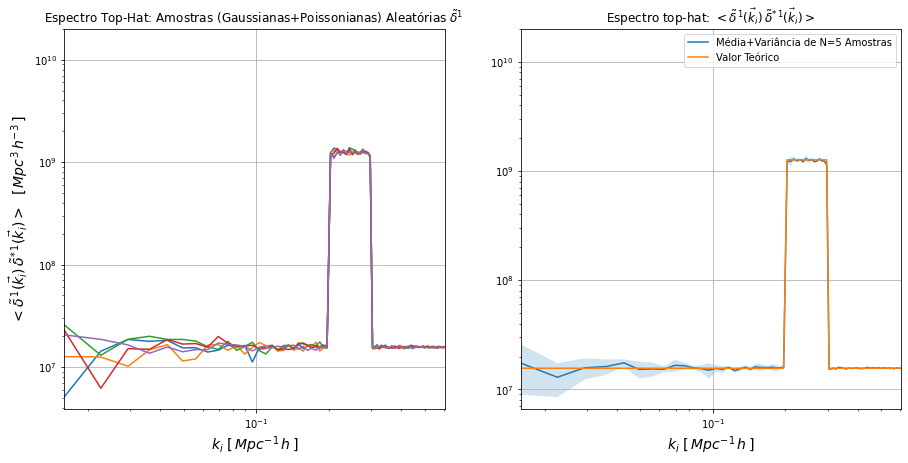

In [23]:
# Constantes do modelo top-hat a serem consideradas:

epsilon=10
k_1=2e-1
k_2=3e-1

# traçador a ser considerado:

bias1=1 # bias
Nbar1=1000 # densidade de contagem do traçador [Delta_L^(-3)]



N_amostras=5 # Número de amostras do campo dos modos de Fourier
ps_samples=np.zeros(shape=(N_amostras,n_k))
ps_mean=np.zeros(n_k)
ps_var=np.zeros(n_k)

# correlação para cada bin, para cada caixa:

for i in range(N_amostras):
    
    ps_samples[i,:]=random_ps_tracers(bias1,Nbar1)

# média das correlações de cada caixa, a fim de obter a expressão final para a função de correlação amostral.
# juntamente, calculamos a variância desta estimativa.

for i in range(n_k):
    
    ps_mean[i] = np.mean(ps_samples[:,i])
    ps_var[i]=np.sqrt(np.cov(ps_samples[:,i]))
    
#### Plot da função obtida #####

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(7)
fig.set_figwidth(15)

# Expressão teórica esperada :

ps_theory=(linear_distance)**3*(Delta_L**3/Nbar1+bias1*bias1*tophat(epsilon,k_1,k_2,k_ctrs))

ax2.loglog(k_ctrs,ps_mean,label=r"Média+Variância de N=%i Amostras" %N_amostras)
ax2.loglog(k_ctrs,ps_theory,label=r"Valor Teórico")
ax2.fill_between(k_ctrs,ps_mean-ps_var,ps_mean+ps_var,alpha=0.2)
ax2.set_xlabel(r"$k_i\,\,[\,Mpc^{-1}\,h\,]$",fontsize=14)
ax2.set_title(r"Espectro top-hat: $<\tilde{\delta}^{\,1}(\vec{k}_i)\,\tilde{\delta}^{*\,1}(\vec{k}_i)>$")
ax2.set_xlim(left=k_ctrs[0],right=k_ctrs[-1])
ax2.legend()
ax2.set_ylim(top=2e10)

for i in range(N_amostras):
    ax1.loglog(k_ctrs,ps_samples[i,:])
    
ax1.set_xlabel(r"$k_i\,\,[\,Mpc^{-1}\,h\,]$",fontsize=14)
ax1.set_title(r"Espectro Top-Hat: Amostras (Gaussianas+Poissonianas) Aleatórias $\tilde{\delta}^1$ ")
ax1.set_ylabel(r"$<\tilde{\delta}^{\,1}(\vec{k}_i)\,\tilde{\delta}^{*\,1}(\vec{k}_i)>\,\,\,\,[\,Mpc^3\,h^{-3}\,]$",fontsize=14)
ax1.set_xlim(left=k_ctrs[0],right=k_ctrs[-1])
ax1.set_ylim(top=2e10)

ax1.grid()
ax2.grid()

plt.show()


Com todas as expressões em concordância, podemos partir para o cálculo das funções de correlação dos modos harmônicos:

In [10]:
# Simulação :


# Constantes do modelo Top-Hat:

epsilon=10
k_1=2e-1
k_2=3e-1

# traçador(es)

biass=[1]
N_bars=[1000]

# valor(es) de l:
l_1=[10]

# valores de r1 e r2 :

r_1=np.linspace(5,245,25)
r_2=np.linspace(5,245,25)

# espessura dos bins radiais

W=10 # h^(-1) Mpc

# número de caixas a serem tomadas :

N_simulations=100

# Início do cálculo:

inicio=time.time()

simulation_1=Angular_PS_tracers(N_simulations,l_1,biass,N_bars,r_1,r_2,W)

# Fim do cálculo:

fim=time.time()

# Salvando a simulação

np.save(r"simulacao_apendice",simulation_1)

# Print do tempo tomado para a simulação

print((fim-inicio)/60, 'minutos')

31.686371274789174 minutos


Terminada a simulação, podemos carregá-la a partir do arquivo salvo no computador, sem a necessidade de refazer a simulação toda vez que abrirmos o programa. Vamos então carregar a simulação realizada e também calcular sua contraparte teórica:

In [24]:
epsilon=10
k_1=2e-1
k_2=3e-1

# Constantes do modelo Top-Hat:

epsilon=10
k_1=2e-1
k_2=3e-1

# traçador(es)

biass=[1]
N_bars=[1000]

# valor(es) de l:
l_1=[10]

# valores de r1 e r2 :

r_1=np.linspace(5,245,25)
r_2=np.linspace(5,245,25)

# espessura dos bins radiais

W=10 # h^(-1) Mpc

# vetor de r para um cálculo em alta resolução da função de correlação harmônica, através da função Angular_PS_theory2.

r_inf=np.linspace(5,245,241)

# Cálculo da contraparte teórica da simulação 

simulation_1_theory=Angular_PS_theory_avg2(l_1,biass,N_bars,r_1,r_2,W)

# Cálculo da versão em alta definição da função de correlação

simth_inf=Angular_PS_theory2(l_1,biass,N_bars,r_inf,r_inf)

# Carregando a simulação armazenada

sim1load=np.load(r"C:\Users\Sony Vaio\simulacao_apendice.NPY") 

Com todas as funções calculadas (amostrais e teóricas), resta agora realizarmos os plots para fins de comparação. A seguir, definimos algumas funções úteis para plots, que foram utilizadas para a realização dos plots exibidos nas seções 5.1 e 5.2 .

In [31]:
# Plot da matriz r1 x r2 da função de correlação, para um dado l (l1) calculado na simulação, e traçadores b1 e b2.

def plot_Cl_r1r2(sim1,simth1,l1,b1,b2,W):
    
    b1_index=int(np.where(biass==np.double(b1))[0])
    b2_index=int(np.where(biass==np.double(b2))[0])    
    l_index=int(np.where(l_1==np.double(l1))[0])
    
    Cl_mean=np.zeros(shape=(len(r_1),len(r_1)))
    
    # Tomando a média dos estimadores da função de correlação amostral
    
    for i in range(len(r_1)):
        for j in range(len(r_2)):
            
            Cl_mean[i,j]=np.real(np.mean(sim1[:,l_index,b1_index,b2_index,i,j]))
    
    # Tomando a contraparte teórica dessa seção da simulação
    
    Cl_theory=np.real(simth1[l_index,b1_index,b2_index,:,:])
    
    
    # Plots
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

    fig.set_figheight(15)
    fig.set_figwidth(22)
    
    ## Plots das funções teórica e amostral, paineis superiores ##
    
    img1 = ax1.imshow(Cl_mean)
    
    ax1.set_title(r"$C_{%i,obs}^{%i\,%i}\,(\overline{r},\overline{r}')$ com espessura de bin $W =%i\,\,Mpc\,h^{-1}$"%(l1,b1,b2,W),fontsize=20)
    ax1.set_xlabel(r"$\overline{r}\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax1.set_ylabel(r"$\overline{r}'\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    
    ax1.set_xticks(np.linspace(0,len(r_1)-1,6));
    ax1.set_xticklabels(np.linspace(np.min(r_1),np.max(r_1),6))

    ax1.set_yticks(np.linspace(0,len(r_1)-1,11));
    ax1.set_yticklabels(np.linspace(np.min(r_1),np.max(r_1),11))
    ax1.tick_params(labelsize=14)
    fig.colorbar(img1,ax=ax1,fraction=0.046, pad=0.04)
    
    #####
    
    img2 = ax2.imshow(Cl_theory)
    
    ax2.set_title(r"$ C_{%i,th}^{%i\,%i}\,(\overline{r},\overline{r}')$ com espessura de bin $W =%i\,\,Mpc\,h^{-1}$"%(l1,b1,b2,W),fontsize=20)
    ax2.set_xlabel(r"$\overline{r}\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax2.set_ylabel(r"$\overline{r}'\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax2.tick_params(labelsize=14)
    ax2.set_xticks(np.linspace(0,len(r_1)-1,6));
    ax2.set_xticklabels(np.linspace(np.min(r_1),np.max(r_1),6))

    ax2.set_yticks(np.linspace(0,len(r_1)-1,11));
    ax2.set_yticklabels(np.linspace(np.min(r_1),np.max(r_1),11))
    
    fig.colorbar(img2,ax=ax2,fraction=0.046, pad=0.04)
    
    ## Plot dos resíduos, painel inferior esquerdo ##
    
    residual1=(Cl_mean-Cl_theory)/Cl_theory
    
    img3 = ax3.imshow(residual1,cmap='bwr')
    fig.colorbar(img3,ax=ax3,fraction=0.046, pad=0.04)
    img3.set_clim(-1, 1)
    ax3.set_xticks(np.linspace(0,len(r_1)-1,6));
    ax3.set_xticklabels(np.linspace(np.min(r_1),np.max(r_1),6))

    ax3.set_yticks(np.linspace(0,len(r_1)-1,11));
    ax3.set_yticklabels(np.linspace(np.min(r_1),np.max(r_1),11))
    ax3.set_title(r"Resíduo $(C_{obs}-C_{th})/C_{th}$" ,fontsize=20)
    ax3.set_xlabel(r"$\overline{r}\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax3.set_ylabel(r"$\overline{r}'\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax3.tick_params(labelsize=14)
    
    ## Plot da seção diagonal da função, painel inferior direito ### 
    
    
    Cl_r1r1=np.zeros(shape=(len(r_1)))
    Cl_r1r1_var=np.zeros(shape=(len(r_1)))
    Cl_r1r1_theory=np.zeros(shape=(len(r_1)))
    Cl_r1r1_var_theory=np.zeros(shape=(len(r_1)))
    
    for i in range(len(r_1)):
         
        # Tomando a seção diagonal da função de correlação amostral 
        
        Cl_r1r1[i]=np.real(np.mean(sim1[:,l_index,b1_index,b2_index,i,i]))
        
        # Tomando a variância dessa estimativa ^
        
        Cl_r1r1_var[i]=np.sqrt(np.var(sim1[:,l_index,b1_index,b2_index,i,i]))
        
        # Tomando a contraparte teórica da seção diagonal da função
        
        Cl_r1r1_theory[i]=np.real(simth1[l_index,b1_index,b2_index,i,i])
    
    for i in range(len(r_1)):
        
        # Tomando a variância teórica da seção diagonal da função de correlação harmônica
        
        Cl_r1r1_var_theory[i]=np.sqrt(2*Cl_r1r1_theory[i]**2/(2*l1+1))
    
    ## interpolando os resultados para uma visualização suavizada ##
    
    Cl_mean_interp=make_interp_spline(r_1,Cl_r1r1)
    
    Cl_var_interp=make_interp_spline(r_1,Cl_r1r1_var)
    
    Cl_theory_interp=make_interp_spline(r_1,Cl_r1r1_theory)
    
    Cl_var_th_interp=make_interp_spline(r_1,Cl_r1r1_var_theory)
    
    r_interp=np.linspace(r_1[0],r_1[-1],5*len(r_1))
    
    ## Plot das funções de correlação diagonais interpoladas ##
    
    ax4.semilogy(r_interp,Cl_mean_interp(r_interp),label='Simulação ($W=10\,\,\,Mpc/h$)')
    ax4.semilogy(r_interp,Cl_theory_interp(r_interp),label='Teórico ($W=%i\,\,\,Mpc/h$)'%W)
    ax4.fill_between(r_interp,Cl_mean_interp(r_interp)-Cl_var_interp(r_interp),Cl_mean_interp(r_interp)+Cl_var_interp(r_interp),alpha=0.2)
    ax4.fill_between(r_interp,Cl_theory_interp(r_interp)-Cl_var_th_interp(r_interp),Cl_theory_interp(r_interp)+Cl_var_th_interp(r_interp),alpha=0.2)
    ax4.set_title(r"$C_{%i}^{%i\,%i}\,(\overline{r},\overline{r})$ com espessura de bin $W =%i\,\,Mpc\,h^{-1}$"%(l1,b1,b2,W),fontsize=20)
    ax4.set_xlabel(r"$\overline{r}\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    ax4.set_ylabel(r"$C_{%i}^{%i\,%i}\,(\overline{r},\overline{r})$"%(l1,b1,b2),fontsize=15)
    ax4.tick_params(labelsize=14)
    ax4.set_xlim(left=r_1[0],right=r_1[-1])
    ax4.set_ylim(bottom=1e-6,top=4e-3)
    ax4.grid()
    ax4.legend(fontsize=16)

    
    
    
    
# Plot da matriz de correlação r1 x r2 dos modos harmônicos, isto é, a matriz da função de correlação normalizada
# por sua própria diagonal:

def plot_Corr_Cl_r1r2(sim1,simth1,sim_inf,l1,b1,b2,W):
    
    b1_index=int(np.where(biass==np.double(b1))[0])
    b2_index=int(np.where(biass==np.double(b2))[0])    
    l_index=int(np.where(l_1==np.double(l1))[0])
    
    Cl_mean=np.zeros(shape=(len(r_1),len(r_1)))
    
    # Tomando a média dos estimadores da função de correlação amostral
    
    for i in range(len(r_1)):
        for j in range(len(r_2)):
            
            Cl_mean[i,j]=np.real(np.mean(sim1[:,l_index,b1_index,b2_index,i,j]))
            
    # Tomando a contraparte teórica dessa seção da simulação
    
    Cl_theory=np.real(simth1[l_index,b1_index,b2_index,:,:])
    
    # Tomando a versão em alta definição para esta seção da simulação
    
    Cl_theory_inf=np.real(sim_inf[l_index,b1_index,b2_index,:,:])
    
    # Plots
    
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3)

    fig.set_figheight(7)
    fig.set_figwidth(21)
    
    ## Tomando as matrizes de correlação ##
    
    cd=Cl_mean
    ct=Cl_theory
    ct_inf=Cl_theory_inf
    
    diag_cd=np.diagonal(cd) # diagonal da função de correlação amostral
    diag_ct=np.diagonal(ct) # diagonal da função de correlação teórica
    diag_ct_inf=np.diagonal(ct_inf) # diagonal da função de correlação teórica, alta resolução
    
    norm_cd=np.outer(np.sqrt(diag_cd),np.sqrt(diag_cd)) # matriz que normalizará cada entrada da função amostral
    norm_ct=np.outer(np.sqrt(diag_ct),np.sqrt(diag_ct)) # matriz que normalizará cada entrada da função teórica
    norm_ct_inf=np.outer(np.sqrt(diag_ct_inf),np.sqrt(diag_ct_inf)) # matriz que normalizará cada entrada da função teórica
                                                                    # em alta resolução
    
    cd_norm=cd/norm_cd # matriz de correlação amostral
    ct_norm=ct/norm_ct # matriz de correlação teórica
    ct_norm_inf=ct_inf/norm_ct_inf # matriz de correlação teórica, alta resolução
    
    
    ####
    
    img1 = ax1.imshow(ct_norm_inf)
    
    ax1.set_title(r"$Corr_{\ell,Th}\,(r,r\,')$ , $\ell=%i$"%l1,fontsize=25)
    ax1.set_xlabel(r"$\overline{r}\,\,\,[\,h^{-1}\,Mpc\,]$",fontsize=25)
    ax1.set_ylabel(r"$\overline{r}\,'\,\,\,[\,h^{-1}\,Mpc\,]$",fontsize=25)
    
    ax1.set_xticks((int(3.5*len(r_inf)/len(r_1)),int(7.5*len(r_inf)/len(r_1)),int(11.5*len(r_inf)/len(r_1)),int(15.5*len(r_inf)/len(r_1)),int(19.5*len(r_inf)/len(r_1)),int(23.5*len(r_inf)/len(r_1))));
    ax1.set_xticklabels((40,80,120,160,200,240))

    ax1.set_yticks((int(3.5*len(r_inf)/len(r_1)),int(7.5*len(r_inf)/len(r_1)),int(11.5*len(r_inf)/len(r_1)),int(15.5*len(r_inf)/len(r_1)),int(19.5*len(r_inf)/len(r_1)),int(23.5*len(r_inf)/len(r_1))));
    ax1.set_yticklabels((40,80,120,160,200,240))
    ax1.tick_params(labelsize=20) 
    
    
    ####
    
    img2 = ax2.imshow(ct_norm)
    
    ax2.set_title(r"$Corr_{\ell,Th}\,(\overline{r},\overline{r}\,')$ , $\ell=%i$"%l1,fontsize=25)
    ax2.set_xlabel(r"$\overline{r}\,\,\,[\,h^{-1}\,Mpc\,]$",fontsize=25)
    
    ax2.set_xticks((3.5,7.5,11.5,15.5,19.5,23.5));
    ax2.set_xticklabels((40,80,120,160,200,240))

    ax2.tick_params(labelleft=False,left=False,right=False,labelsize=20)
    
    #####
    
    img3 = ax3.imshow(cd_norm)
    
    ax3.set_title(r"$Corr_{\ell,Sim}\,(\overline{r},\overline{r}\,')$ , $\ell=%i$"%l1,fontsize=25)
    ax3.set_xlabel(r"$\overline{r}\,\,\,[\,h^{-1}\,Mpc\,]$",fontsize=25)
    
    ax3.set_xticks((3.5,7.5,11.5,15.5,19.5,23.5));
    ax3.set_xticklabels((40,80,120,160,200,240))

    ax3.set_yticks((3.5,7.5,11.5,15.5,19.5,23.5));
    ax3.set_yticklabels((40,80,120,160,200,240))
    ax3.yaxis.set_ticks_position("right")
    
    # barra de cor para os paineis superiores
    
    cbar=fig.colorbar(img3,ax=[ax1,ax2,ax3],fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=20)
    
    ax3.tick_params(labelsize=20)
    

    ## Plot da seção diagonal da função, painel inferior ## 

    Cl_r1r1=np.zeros(shape=(len(r_1)))
    Cl_r1r1_var=np.zeros(shape=(len(r_1)))
    Cl_r1r1_theory=np.zeros(shape=(len(r_1)))
    Cl_r1r1_var_theory=np.zeros(shape=(len(r_1)))
    
    for i in range(len(r_1)):
        
        # Tomando a seção diagonal da função de correlação amostral 
        
        Cl_r1r1[i]=np.real(np.mean(sim1[:,l_index,b1_index,b2_index,i,i]))
        
        # Tomando a variância dessa estimativa ^
        
        Cl_r1r1_var[i]=np.sqrt(np.var(sim1[:,l_index,b1_index,b2_index,i,i]))
        
        # Tomando a contraparte teórica da seção diagonal da função
        
        Cl_r1r1_theory[i]=np.real(simth1[l_index,b1_index,b2_index,i,i])
    
    for i in range(len(r_1)):
        
        # Tomando a variância teórica da seção diagonal da função de correlação harmônica
        
        Cl_r1r1_var_theory[i]=np.sqrt(2*Cl_r1r1_theory[i]**2/(2*l1+1))
        
        
    ## interpolando os resultados para uma visualização suavizada ##
    
    Cl_mean_interp=make_interp_spline(r_1,Cl_r1r1)
    
    Cl_var_interp=make_interp_spline(r_1,Cl_r1r1_var)
    
    Cl_theory_interp=make_interp_spline(r_1,Cl_r1r1_theory)
    
    Cl_var_th_interp=make_interp_spline(r_1,Cl_r1r1_var_theory)
    
    r_interp=np.linspace(r_1[0],r_1[-1],5*len(r_1))
    
    ## Plot das funções de correlação diagonais interpoladas ##
    
    plt.figure(figsize=(21,7))
    plt.semilogy(r_interp,Cl_mean_interp(r_interp),label='Simulação')
    plt.semilogy(r_interp,Cl_theory_interp(r_interp),label='Teórico')
    plt.fill_between(r_interp,Cl_mean_interp(r_interp)-Cl_var_interp(r_interp),Cl_mean_interp(r_interp)+Cl_var_interp(r_interp),alpha=0.2)
    plt.fill_between(r_interp,Cl_theory_interp(r_interp)-Cl_var_th_interp(r_interp),Cl_theory_interp(r_interp)+Cl_var_th_interp(r_interp),alpha=0.2)
    plt.title(r"$C_{\ell}\,(\,\overline{r},\overline{r}\,)$ , $\ell=%i$"%(l1),fontsize=25)
    plt.xlabel(r"$\overline{r}\,\,\,[\,h^{-1}\,Mpc\,]$",fontsize=25)
    plt.ylabel(r"$C_{\ell}\,(\overline{r},\overline{r})$",fontsize=25)
    plt.ylim(bottom=1e-6,top=4e-3)
    plt.xlim(left=r_1[0],right=r_1[-1])
    plt.tick_params(labelsize=25)
    plt.grid()
    plt.legend(fontsize=18)

    
# Função que plota a matriz de correlação do espectro de potência angular, isto é,
#  a matriz de covariância Cov[xi_l(X),xi_l(Y)] normalizada por sua própria diagonal

def plot_complete_tracer_cov_XY_norm(sim1,simth1,l1,b1,b2,b3,b4,W):
    
    # calculando as matrizes de covariância amostral e teórica (complete_cov_r1r2r3r4)
    
    cd,ct=complete_cov_r1r2r3r4(sim1,simth1,l1,b1,b2,b3,b4,W)
    
    # normalizando pela diagonal:
    
    diag_cd=np.diagonal(cd)
    diag_ct=np.diagonal(ct)
    norm_cd=np.outer(np.sqrt(diag_cd),np.sqrt(diag_cd))
    norm_ct=np.outer(np.sqrt(diag_ct),np.sqrt(diag_ct))
    
    cd_norm=cd/norm_cd # matriz de correlação amostral
    ct_norm=ct/norm_ct # matriz de correlação teórica
    
    # matriz de resíduos
    
    residual=cd_norm-ct_norm 
    
    # plot das matrizes
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

    fig.set_figheight(20)
    fig.set_figwidth(22)

    # Matrizes de correlação amostral e teórica ( paineis superiores ) 
    
    img1 = ax1.imshow(cd_norm,cmap='bwr',origin="lower")
    img1.set_clim(-1, 1)
    ax1.set_title(r"$Corr\,[\xi_{\ell}(\mathbf{X}),\xi_{\ell}(\mathbf{Y})]$ Amostral, $\ell=%i$"%l1 ,fontsize=20)
    ax1.set_xlabel(r"$\mathbf{X}$",fontsize=20)
    ax1.set_ylabel(r"$\mathbf{Y}$",fontsize=20)
    ax1.tick_params(labelsize=20)
    
    axins = ax1.inset_axes([0.5, 0.03, 0.47, 0.47])
    img12=axins.imshow(cd_norm, origin="lower",cmap='bwr')
    img12.set_clim(-1, 1)
    
    # sub-região das matriz cd_norm original
    
    x1, x2, y1, y2 = 50, 150, 50, 150
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels([])
    axins.set_yticklabels([])
    ax1.indicate_inset_zoom(axins, edgecolor="black")
    
    cbar=fig.colorbar(img1,ax=[ax1,ax2],fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=20)
    
    img2 = ax2.imshow(ct_norm,cmap='bwr',origin="lower")
    img2.set_clim(-1, 1)
    
    ax2.set_title(r"$Corr\,[\xi_{\ell}(\mathbf{X}),\xi_{\ell}(\mathbf{Y})]$ Teórico, $\ell=%i$"%l1 ,fontsize=20)
    ax2.set_xlabel(r"$\mathbf{X}$",fontsize=20)
    ax2.set_ylabel(r"$\mathbf{Y}$",fontsize=20)
    ax2.tick_params(labelsize=20)
    
    axins2 = ax2.inset_axes([0.5, 0.03, 0.47, 0.47])
    img22=axins2.imshow(ct_norm, origin="lower",cmap='bwr')
    img22.set_clim(-1, 1)
    
    # sub-região das matriz ct_norm original
    
    axins2.set_xlim(x1, x2)
    axins2.set_ylim(y1, y2)
    axins2.set_xticklabels([])
    axins2.set_yticklabels([])
    ax2.indicate_inset_zoom(axins2, edgecolor="black")
    
    ### Plot dos resíduos , e zoom no canto inferior esquerdo dos resíduos ( paineis inferiores )  ###
    
    img4 = ax4.imshow(residual,cmap='bwr',origin="lower")
    img4.set_clim(-1, 1)
    ax4.set_title(r"Resíduos (Zoom do Canto Inferior Esquerdo)",fontsize=20)
    ax4.set_xlabel(r"$\mathbf{X}$",fontsize=15)
    ax4.set_ylabel(r"$\mathbf{Y}$",fontsize=15)
    ax4.set_ylim(0,50)
    ax4.set_xlim(0,50)
    ax4.tick_params(labelsize=20)
    
    img3 = ax3.imshow(residual,cmap='bwr',origin="lower")
    img3.set_clim(-1, 1)
    ax3.set_title(r"Resíduos",fontsize=20)
    ax3.set_xlabel(r"$\mathbf{X}$",fontsize=20)
    ax3.set_ylabel(r"$\mathbf{Y}$",fontsize=20)
    ax3.tick_params(labelsize=20)

# Plot que mostra uma comparação direta entre a versão infinitesimal da função de correlação harmônica (Angular_PS_theory2),
# versus a versão 'binada', para um l (l1), b1 e b2 fixos, e um vetor de espessuras (Ws) fornecido: 

def plot_Cl_vs_W(l1,b1,b2,Ws):
    
    
    b1_index=int(np.where(biass==np.double(b1))[0])
    b2_index=int(np.where(biass==np.double(b2))[0])    
    l_index=int(np.where(l_1==np.double(l1))[0])
    
    # cálculo da versão infinitesimal
    
    infinitesimal_th=np.real(Angular_PS_theory2(l_1,biass,N_bars,r_1,r_2))
    infinitesimal_r1r1=np.zeros(len(r_1))
    
    # seção diagonal da função de correlação infinitesimal
    
    for i in range(len(r_1)):
        
        infinitesimal_r1r1[i]=infinitesimal_th[l_index,b1_index,b2_index,i,i]
        
    # interpolação da versão infinitesimal, para visualização suavizada
    
    infinitesimal_r1r1_interp=make_interp_spline(r_1,infinitesimal_r1r1)    
    r_interp=np.linspace(r_1[0],r_1[-1],5*len(r_1))
    

    plt.figure(figsize=(14,10))
    
    # plot da versão infinitesimal
    
    plt.semilogy(r_interp,infinitesimal_r1r1_interp(r_interp),label=r"bin infinitesimal",linewidth=3,alpha=0.7)
    
    # plots das versões binadas :
    
    for i in range(len(Ws)):
        
        # cálculo da versão binada, com espessura de bin Ws[i]
        
        simth=Angular_PS_theory_avg2(l_1,biass,N_bars,r_1,r_2,Ws[i])
        
        th_Cl_r1r1=np.zeros(len(r_1))
        
        # seção diagonal desta função de correlação ^
        
        for j in range(len(r_1)):
            
            th_Cl_r1r1[j]=simth[l_index,b1_index,b2_index,j,j]
        
        # interpolação da seção diagonal, para visualização suavizada
        
        Cl_r1r1_interp=make_interp_spline(r_1,th_Cl_r1r1)
        
        # plot da versão binada
        
        plt.semilogy(r_interp,Cl_r1r1_interp(r_interp),label=r"$W=%.2f\,\,\,Mpc\,h^{-1}$"%Ws[i],linestyle='-.')
    
    plt.title(r"$C_{%i}^{%i\,,%i}\,(\overline{r},\overline{r})$ para diferentes espessuras de bin $W$"%(l1,b1,b2) ,fontsize=15)
    plt.xlabel(r"$\overline{r}\,\,\,[Mpc\,h^{-1}]$",fontsize=15)
    plt.ylabel(r"$C_{%i}^{%i\,%i}\,(\overline{r},\overline{r})$"%(l1,b1,b2),fontsize=15)
    plt.xlim(left=r_1[0],right=150)
    plt.ylim(top=1e-3,bottom=1e-5)
    plt.legend(fontsize=16)
    plt.grid()
    plt.show()
    

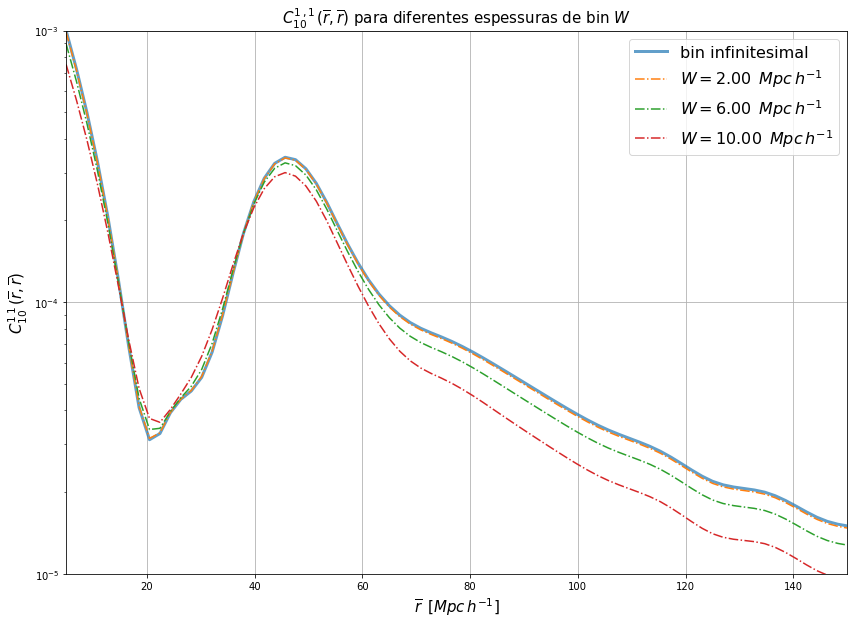

In [32]:
plot_Cl_vs_W(10,1,1,np.linspace(2,10,3))

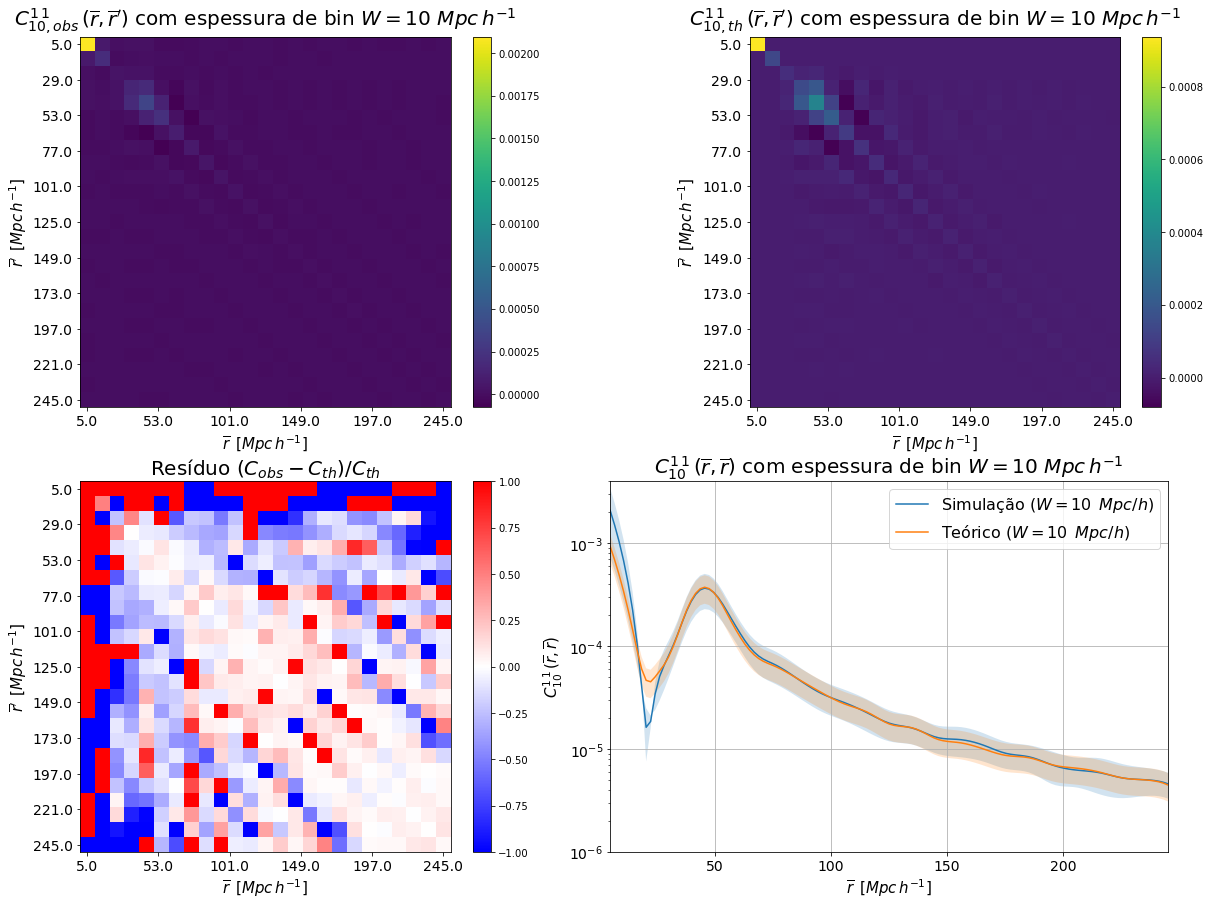

In [26]:
plot_Cl_r1r2(sim1load,1.25*simulation_1_theory,10,1,1,W)

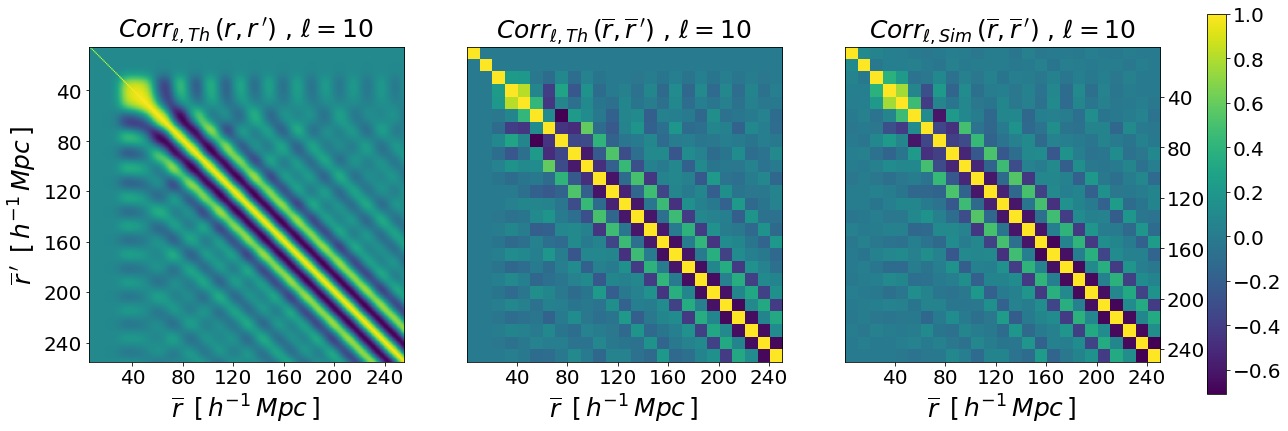

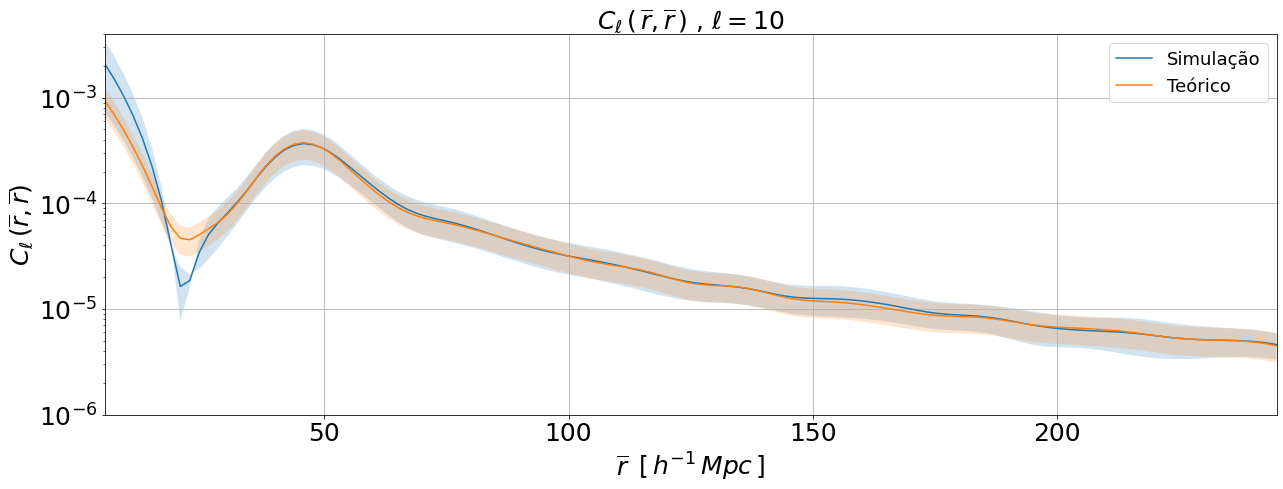

In [27]:
plot_Corr_Cl_r1r2(sim1load,1.25*simulation_1_theory,simth_inf,10,1,1,W)

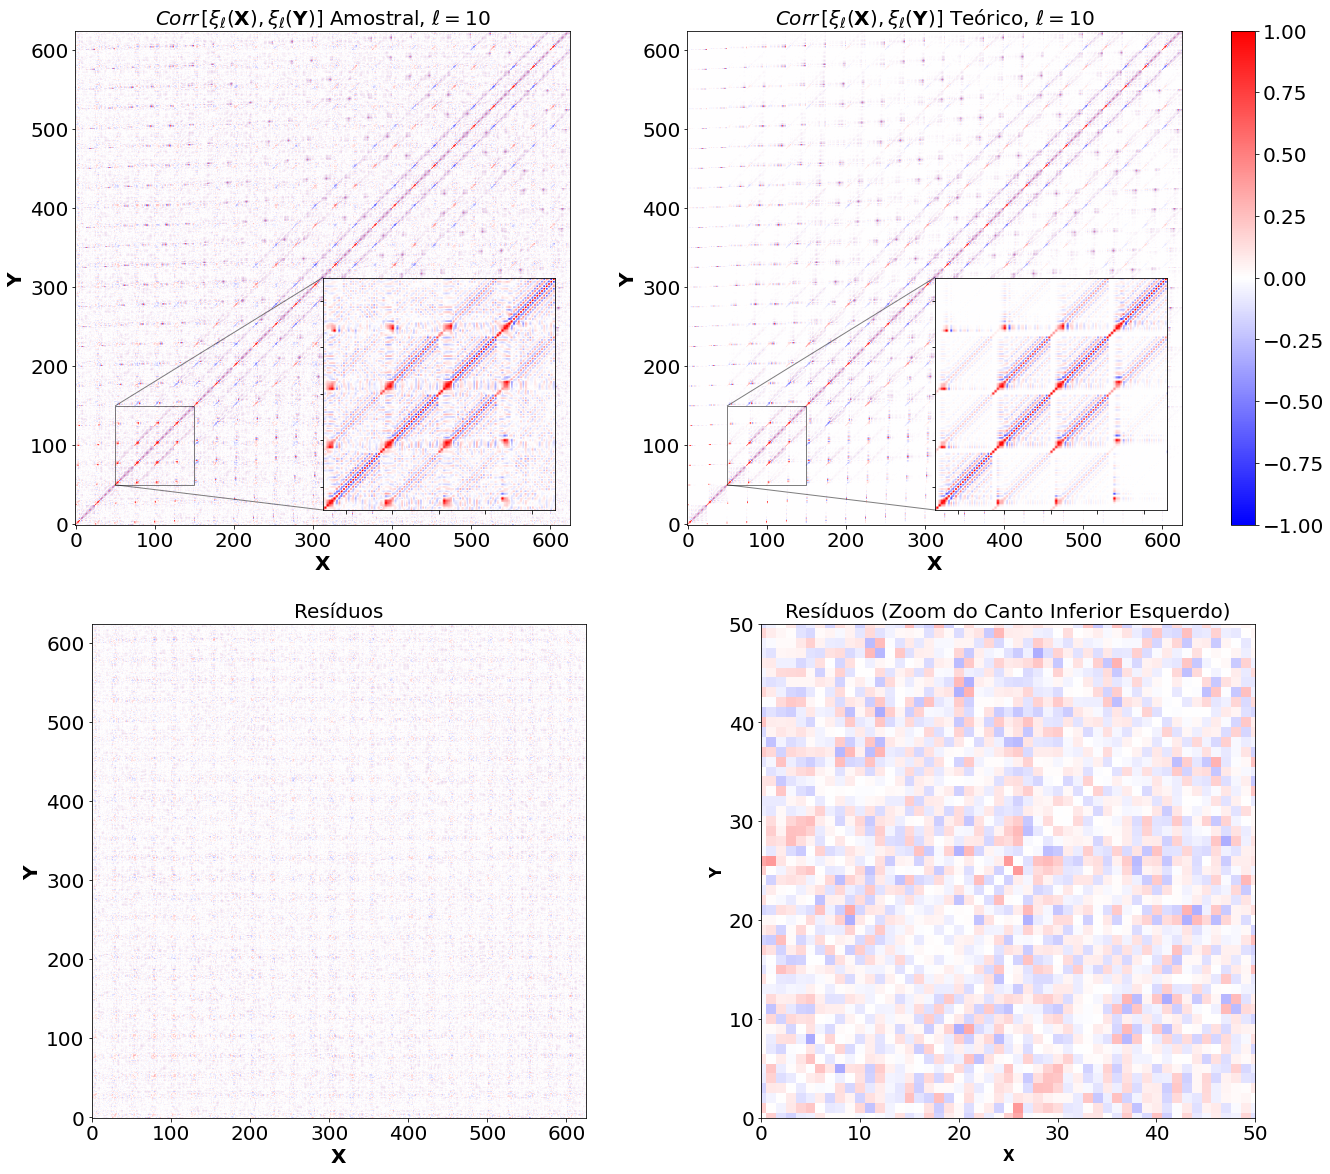

In [30]:
plot_complete_tracer_cov_XY_norm(sim1load,1.25*simulation_1_theory,10,1,1,1,1,10)

In [36]:
jupyter nbconvert C:\Users\Sony Vaio\Downloads\appendix1.ipynb --to latex

SyntaxError: invalid syntax (Temp/ipykernel_10848/3939622745.py, line 1)